In [1]:
import numpy as np
import os
from src.utils import *
from src.reinforcement import *
from src.metrics import *
from src.features import *
from src.image_helper import *
from PIL import Image
from keras.applications.vgg16 import VGG16
import numpy as np
import random
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

Using TensorFlow backend.


In [2]:
search_image = np.array(Image.open('/home/workspace/keras-person-search/data/psdb/dataset/Image/SSM/s8678.jpg'))
target_image = np.array(
    Image.open('/home/workspace/keras-person-search/data/psdb/dataset/Image/SSM/s8678.jpg')
)[119:772,323:551]

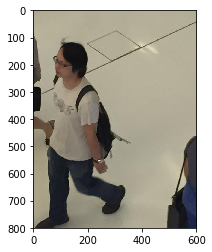

In [3]:
plt.imshow(search_image)

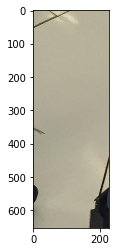

In [4]:
plt.imshow(target_image)

In [5]:
fm_model = VGG16(weights='imagenet')
rl_model = get_q_network('./output/model/model6_epoch.h5')

ValueError: You are trying to load a weight file containing 3 layers into a model with 4 layers.

In [ ]:
scale_subregion = float(3)/4
scale_mask = float(1)/(scale_subregion*4)
# Number of steps that the agent does at each image
number_of_steps = 10
# Only search first object
only_first_object = 1
qval = 0
offset = (0, 0)

In [ ]:
region_image = search_image
#while step < number_of_steps:
iou = 0
history_vector = np.zeros([24])

search_iv = get_image_vector(region_image, fm_model)
target_iv = get_image_vector(target_image, fm_model)
state = get_state(target_iv, search_iv, history_vector)

size_mask = (region_image.shape[0], region_image.shape[1])
original_shape = size_mask

region_masks = []
region_mask = np.ones([region_image.shape[0], region_image.shape[1]])
region_masks.append(region_mask)

step = 0
start = time.time()
while step < number_of_steps:
    step += 1
    qval = rl_model.predict(state.T, batch_size=1)
    action = (np.argmax(qval))+1

    if action != 6:
        region_mask = np.zeros(original_shape)
        size_mask = (size_mask[0] * scale_subregion, size_mask[1] * scale_subregion)
        region_image, region_mask = do_action(action, region_image, region_mask, offset, size_mask, scale_mask)
        region_masks.append(region_mask)
    else:
        offset = (0, 0)
        if step == 1:
            absolute_status = 0
        if only_first_object == 1:
            absolute_status = 0
        image_for_search = mask_image_with_mean_background(region_mask, search_image)
        region_image = image_for_search
        print('find target!')
        break
    print(step)

    history_vector = update_history_vector(history_vector, action)
    search_iv = get_image_vector(region_image, fm_model)
    target_iv = get_image_vector(target_image, fm_model)
    state = get_state(target_iv, search_iv, history_vector)
print('time cost: ', time.time() - start)

In [ ]:
plt.imshow(mask_image_with_mean_background(region_masks[-2], search_image))